**Step 1: Image Segmentation**

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 147MB/s]  
Processing Images: 100%|██████████| 100/100 [06:02<00:00,  3.62s/it]


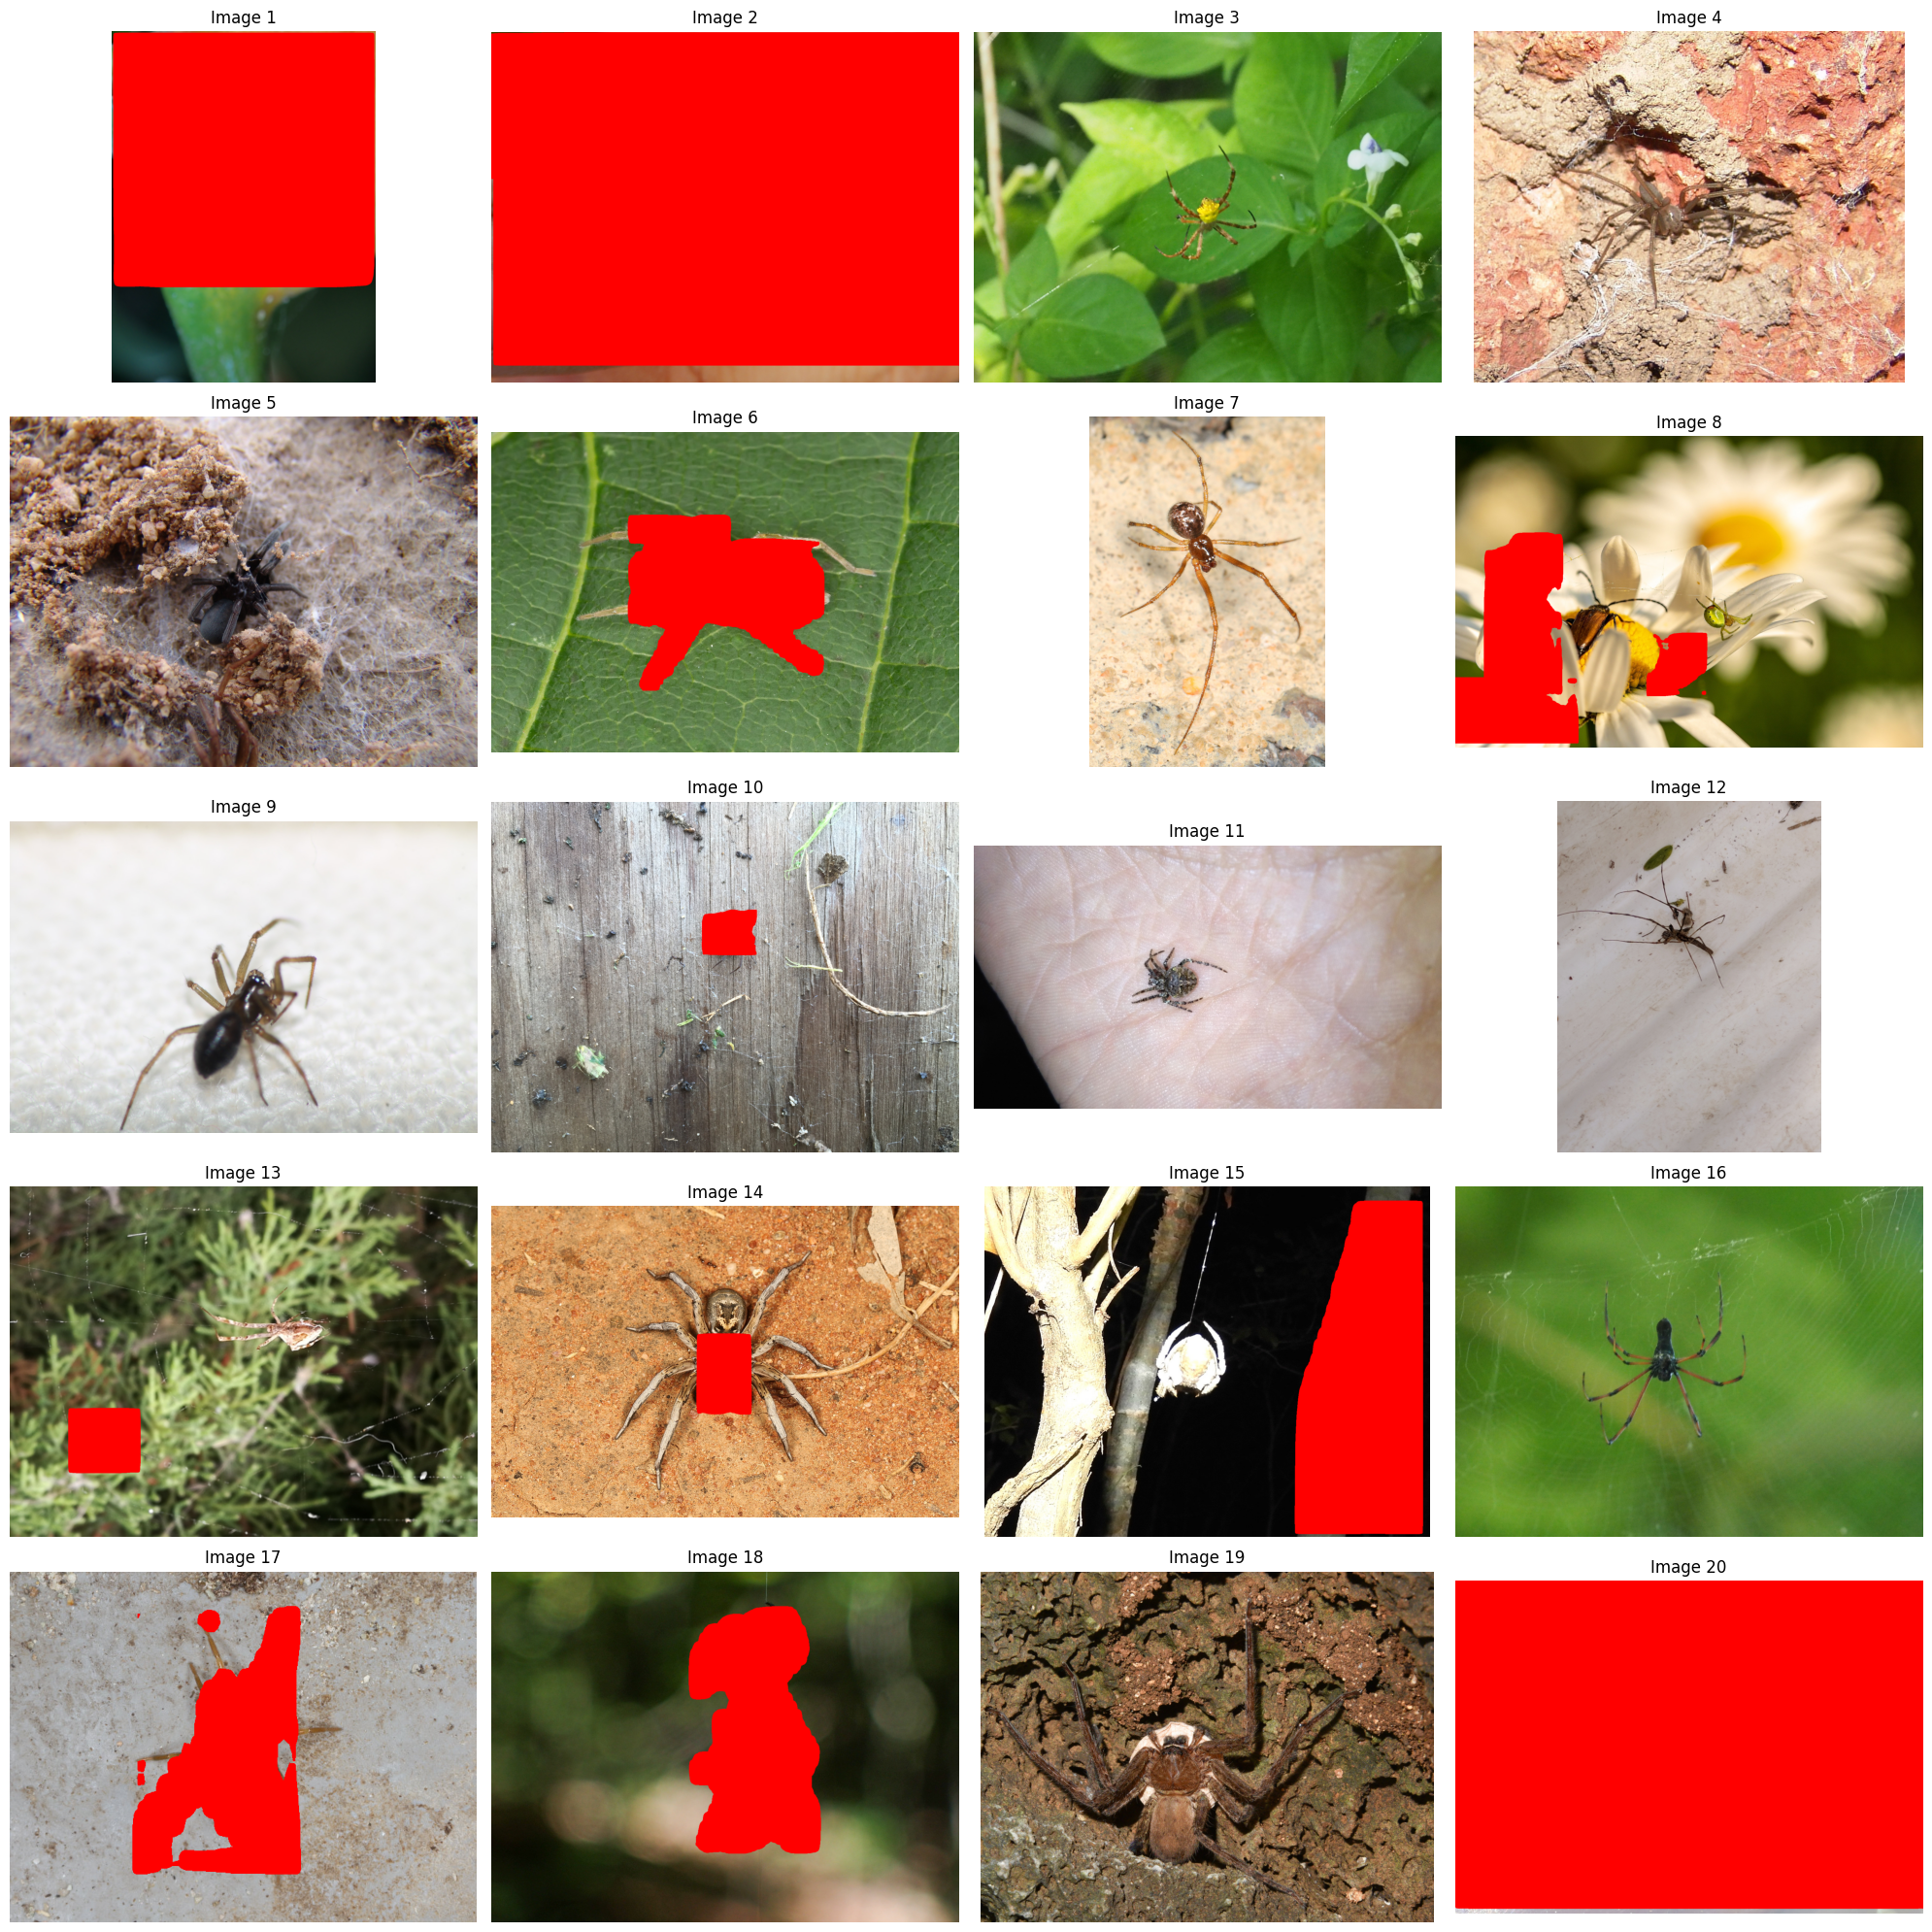

In [1]:
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # For displaying a progress bar

# Load the pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Function to display segmented objects in an image
def display_segmented_image(image, predictions, threshold=0.5):
    image_np = np.array(image)
    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            image_np[mask > 0] = (255, 0, 0)
    return image_np

# Process and display multiple images
num_images_to_display = 20  # Adjust this if you want to display more or fewer images
plt.figure(figsize=(20, 20))

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Display segmented objects
    segmented_image = display_segmented_image(image, predictions)

    # Plot the segmented image (only the first `num_images_to_display` images)
    if idx < num_images_to_display:
        plt.subplot(5, 4, idx + 1)  # Create a 5x4 grid
        plt.imshow(segmented_image)
        plt.axis('off')
        plt.title(f'Image {idx + 1}')

plt.tight_layout()
plt.show()


**Step 2: Object Extraction and Storage**

In [2]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # For displaying a progress bar
import json

# Load the pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

# Transform to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create a directory to save the segmented objects
os.makedirs('segmented_objects', exist_ok=True)

# Extract and save each segmented object
def save_segmented_objects(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    metadata = []

    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            object_image = Image.fromarray(image_np * (mask[:, :, None] > 0))
            object_id_str = f'{master_id}_obj_{object_id:03d}'
            object_image.save(f'segmented_objects/{object_id_str}.png')
            metadata.append({'object_id': object_id_str, 'master_id': master_id})
            object_id += 1
    
    return metadata

# Main loop to process images and save segmented objects
all_metadata = []

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Generate a master ID for the current image
    master_id = f'image_{idx:03d}'
    
    # Save segmented objects and get metadata
    metadata = save_segmented_objects(image, predictions, master_id)
    all_metadata.extend(metadata)

# Save all metadata to a JSON file
with open('segmented_objects_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)

print("Segmentation and saving completed.")


Processing Images: 100%|██████████| 100/100 [06:26<00:00,  3.86s/it]

Segmentation and saving completed.


**Step 3: Object Identification**

In [3]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # For displaying a progress bar
import json

# Load the pre-trained Mask R-CNN model
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

# Load the pre-trained Faster R-CNN model
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

# Transform to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create a directory to save the segmented objects
os.makedirs('segmented_objects', exist_ok=True)

# Extract and save each segmented object
def save_segmented_objects(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    metadata = []

    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            object_image = Image.fromarray(image_np * (mask[:, :, None] > 0))
            object_id_str = f'{master_id}_obj_{object_id:03d}'
            object_image.save(f'segmented_objects/{object_id_str}.png')
            metadata.append({'object_id': object_id_str, 'master_id': master_id})
            object_id += 1
    
    return metadata

# Main loop to process images and save segmented objects
all_metadata = []

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = mask_rcnn_model(image_tensor)
    
    # Generate a master ID for the current image
    master_id = f'image_{idx:03d}'
    
    # Save segmented objects and get metadata
    metadata = save_segmented_objects(image, predictions, master_id)
    all_metadata.extend(metadata)

# Save all metadata to a JSON file
with open('segmented_objects_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)

print("Segmentation and saving completed.")

# Identify and describe each object
def identify_objects(metadata):
    descriptions = []
    for item in tqdm(metadata, desc="Identifying Objects"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path).convert("RGB")
        object_tensor = transform(object_image).unsqueeze(0)

        with torch.no_grad():
            obj_predictions = faster_rcnn_model(object_tensor)
        
        labels = obj_predictions[0]['labels'].cpu().numpy()
        scores = obj_predictions[0]['scores'].cpu().numpy()
        description = [{'label': int(label), 'score': float(score)} for label, score in zip(labels, scores)]
        
        descriptions.append({'object_id': item['object_id'], 'description': description})
    
    return descriptions

# Load metadata
with open('segmented_objects_metadata.json', 'r') as f:
    metadata = json.load(f)

# Identify and describe objects
descriptions = identify_objects(metadata)

# Save descriptions to a JSON file
with open('object_descriptions.json', 'w') as f:
    json.dump(descriptions, f, indent=4)

print("Object identification completed.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 143MB/s]  
Processing Images: 100%|██████████| 100/100 [06:30<00:00,  3.91s/it]


Segmentation and saving completed.


Identifying Objects: 100%|██████████| 103/103 [05:55<00:00,  3.45s/it]

Object identification completed.


**Step 4: Text/Data Extraction from Objects**

In [4]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # For displaying a progress bar
import json
import pytesseract

# Load the pre-trained Mask R-CNN model
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

# Load the pre-trained Faster R-CNN model
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

# Transform to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create a directory to save the segmented objects
os.makedirs('segmented_objects', exist_ok=True)

# Extract and save each segmented object
def save_segmented_objects(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    metadata = []

    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            object_image = Image.fromarray(image_np * (mask[:, :, None] > 0))
            object_id_str = f'{master_id}_obj_{object_id:03d}'
            object_image.save(f'segmented_objects/{object_id_str}.png')
            metadata.append({'object_id': object_id_str, 'master_id': master_id})
            object_id += 1
    
    return metadata

# Main loop to process images and save segmented objects
all_metadata = []

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = mask_rcnn_model(image_tensor)
    
    # Generate a master ID for the current image
    master_id = f'image_{idx:03d}'
    
    # Save segmented objects and get metadata
    metadata = save_segmented_objects(image, predictions, master_id)
    all_metadata.extend(metadata)

# Save all metadata to a JSON file
with open('segmented_objects_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)

print("Segmentation and saving completed.")

# Identify and describe each object
def identify_objects(metadata):
    descriptions = []
    for item in tqdm(metadata, desc="Identifying Objects"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path).convert("RGB")
        object_tensor = transform(object_image).unsqueeze(0)

        with torch.no_grad():
            obj_predictions = faster_rcnn_model(object_tensor)
        
        labels = obj_predictions[0]['labels'].cpu().numpy()
        scores = obj_predictions[0]['scores'].cpu().numpy()
        description = [{'label': int(label), 'score': float(score)} for label, score in zip(labels, scores)]
        
        descriptions.append({'object_id': item['object_id'], 'description': description})
    
    return descriptions

# Identify and describe objects
descriptions = identify_objects(all_metadata)

# Save descriptions to a JSON file
with open('object_descriptions.json', 'w') as f:
    json.dump(descriptions, f, indent=4)

print("Object identification completed.")

# Extract text/data from each object image
def extract_text(metadata):
    extracted_texts = []
    for item in tqdm(metadata, desc="Extracting Text"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path)
        text = pytesseract.image_to_string(object_image)
        extracted_texts.append({'object_id': item['object_id'], 'text': text})
    
    return extracted_texts

# Extract text from objects
extracted_texts = extract_text(all_metadata)

# Save extracted text to a JSON file
with open('extracted_texts.json', 'w') as f:
    json.dump(extracted_texts, f, indent=4)

print("Text extraction completed.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weig

Segmentation and saving completed.


Identifying Objects: 100%|██████████| 103/103 [05:24<00:00,  3.15s/it]


Object identification completed.


Extracting Text: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]

Text extraction completed.


**Step 5: Summarize Object Attributes**

In [5]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # For displaying a progress bar
import json
import pytesseract
from transformers import pipeline
import re

# Load the pre-trained Mask R-CNN model
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

# Load the pre-trained Faster R-CNN model
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

# Transform to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create a directory to save the segmented objects
os.makedirs('segmented_objects', exist_ok=True)

# Extract and save each segmented object
def save_segmented_objects(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    metadata = []

    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            object_image = Image.fromarray(image_np * (mask[:, :, None] > 0))
            object_id_str = f'{master_id}_obj_{object_id:03d}'
            object_image.save(f'segmented_objects/{object_id_str}.png')
            metadata.append({'object_id': object_id_str, 'master_id': master_id})
            object_id += 1
    
    return metadata

# Main loop to process images and save segmented objects
all_metadata = []

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = mask_rcnn_model(image_tensor)
    
    # Generate a master ID for the current image
    master_id = f'image_{idx:03d}'
    
    # Save segmented objects and get metadata
    metadata = save_segmented_objects(image, predictions, master_id)
    all_metadata.extend(metadata)

# Save all metadata to a JSON file
with open('segmented_objects_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)

print("Segmentation and saving completed.")

# Identify and describe each object
def identify_objects(metadata):
    descriptions = []
    for item in tqdm(metadata, desc="Identifying Objects"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path).convert("RGB")
        object_tensor = transform(object_image).unsqueeze(0)

        with torch.no_grad():
            obj_predictions = faster_rcnn_model(object_tensor)
        
        labels = obj_predictions[0]['labels'].cpu().numpy()
        scores = obj_predictions[0]['scores'].cpu().numpy()
        description = [{'label': int(label), 'score': float(score)} for label, score in zip(labels, scores)]
        
        descriptions.append({'object_id': item['object_id'], 'description': description})
    
    return descriptions

# Identify and describe objects
descriptions = identify_objects(all_metadata)

# Save descriptions to a JSON file
with open('object_descriptions.json', 'w') as f:
    json.dump(descriptions, f, indent=4)

print("Object identification completed.")

# Extract text/data from each object image
def extract_text(metadata):
    extracted_texts = []
    for item in tqdm(metadata, desc="Extracting Text"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path)
        text = pytesseract.image_to_string(object_image)
        extracted_texts.append({'object_id': item['object_id'], 'text': text})
    
    return extracted_texts

# Extract text from objects
extracted_texts = extract_text(all_metadata)

# Save extracted text to a JSON file
with open('extracted_texts.json', 'w') as f:
    json.dump(extracted_texts, f, indent=4)

print("Text extraction completed.")

# Load summarization model
summarizer = pipeline("summarization")

# Function to remove punctuation from text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Summarize attributes
def summarize_attributes(extracted_texts):
    summaries = []
    for item in tqdm(extracted_texts, desc="Summarizing Text"):
        # Remove punctuation from the text
        cleaned_text = remove_punctuation(item['text'])
        # Summarize the cleaned text
        if cleaned_text.strip():  # Check if there is any text left after cleaning
            summary = summarizer(cleaned_text, max_length=30, min_length=10, do_sample=False)
            summaries.append({'object_id': item['object_id'], 'summary': summary[0]['summary_text']})
        else:
            summaries.append({'object_id': item['object_id'], 'summary': ''})
    
    return summaries

# Summarize attributes for the dataset
summaries = summarize_attributes(extracted_texts)

# Save summaries to a JSON file
with open('summarized_texts.json', 'w') as f:
    json.dump(summaries, f, indent=4)

print("Text summarization completed.")


2024-08-20 16:35:08.229488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 16:35:08.229599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 16:35:08.362202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights'

Segmentation and saving completed.


Identifying Objects: 100%|██████████| 103/103 [05:46<00:00,  3.37s/it]


Object identification completed.


Extracting Text: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text extraction completed.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Summarizing Text: 100%|██████████| 103/103 [00:00<00:00, 159473.35it/s]

Text summarization completed.


**Step 6: Data Mapping**

In [6]:
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from tqdm import tqdm  # For displaying a progress bar
import json
import pytesseract
from transformers import pipeline
import re

# Load the pre-trained Mask R-CNN model
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

# Load the pre-trained Faster R-CNN model
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

# Define the image paths (replace with your actual paths)
image_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae'  # Replace with your directory path
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:100]]  # Get first 1000 images

# Transform to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create a directory to save the segmented objects
os.makedirs('segmented_objects', exist_ok=True)

# Extract and save each segmented object
def save_segmented_objects(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    metadata = []

    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            object_image = Image.fromarray(image_np * (mask[:, :, None] > 0))
            object_id_str = f'{master_id}_obj_{object_id:03d}'
            object_image.save(f'segmented_objects/{object_id_str}.png')
            metadata.append({'object_id': object_id_str, 'master_id': master_id})
            object_id += 1
    
    return metadata

# Main loop to process images and save segmented objects
all_metadata = []

for idx, image_path in enumerate(tqdm(image_paths, desc="Processing Images")):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Perform image segmentation
    with torch.no_grad():
        predictions = mask_rcnn_model(image_tensor)
    
    # Generate a master ID for the current image
    master_id = f'image_{idx:03d}'
    
    # Save segmented objects and get metadata
    metadata = save_segmented_objects(image, predictions, master_id)
    all_metadata.extend(metadata)

# Save all metadata to a JSON file
with open('segmented_objects_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=4)

print("Segmentation and saving completed.")

# Identify and describe each object
def identify_objects(metadata):
    descriptions = []
    for item in tqdm(metadata, desc="Identifying Objects"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path).convert("RGB")
        object_tensor = transform(object_image).unsqueeze(0)

        with torch.no_grad():
            obj_predictions = faster_rcnn_model(object_tensor)
        
        labels = obj_predictions[0]['labels'].cpu().numpy()
        scores = obj_predictions[0]['scores'].cpu().numpy()
        description = [{'label': int(label), 'score': float(score)} for label, score in zip(labels, scores)]
        
        descriptions.append({'object_id': item['object_id'], 'description': description})
    
    return descriptions

# Identify and describe objects
descriptions = identify_objects(all_metadata)

# Save descriptions to a JSON file
with open('object_descriptions.json', 'w') as f:
    json.dump(descriptions, f, indent=4)

print("Object identification completed.")

# Extract text/data from each object image
def extract_text(metadata):
    extracted_texts = []
    for item in tqdm(metadata, desc="Extracting Text"):
        object_image_path = f'segmented_objects/{item["object_id"]}.png'
        object_image = Image.open(object_image_path)
        text = pytesseract.image_to_string(object_image)
        extracted_texts.append({'object_id': item['object_id'], 'text': text})
    
    return extracted_texts

# Extract text from objects
extracted_texts = extract_text(all_metadata)

# Save extracted text to a JSON file
with open('extracted_texts.json', 'w') as f:
    json.dump(extracted_texts, f, indent=4)

print("Text extraction completed.")

# Load summarization model
summarizer = pipeline("summarization")

# Function to remove punctuation from text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Summarize attributes
def summarize_attributes(extracted_texts):
    summaries = []
    for item in tqdm(extracted_texts, desc="Summarizing Text"):
        # Remove punctuation from the text
        cleaned_text = remove_punctuation(item['text'])
        # Summarize the cleaned text
        if cleaned_text.strip():  # Check if there is any text left after cleaning
            summary = summarizer(cleaned_text, max_length=30, min_length=10, do_sample=False)
            summaries.append({'object_id': item['object_id'], 'summary': summary[0]['summary_text']})
        else:
            summaries.append({'object_id': item['object_id'], 'summary': ''})
    
    return summaries

# Summarize attributes for the dataset
summaries = summarize_attributes(extracted_texts)

# Save summaries to a JSON file
with open('summarized_texts.json', 'w') as f:
    json.dump(summaries, f, indent=4)

print("Text summarization completed.")

# Map all data and attributes
def map_data(metadata, descriptions, extracted_texts, summaries):
    data_mapping = []
    for item in metadata:
        description = next((desc for desc in descriptions if desc['object_id'] == item['object_id']), {})
        text_data = next((text for text in extracted_texts if text['object_id'] == item['object_id']), {})
        summary = next((sum for sum in summaries if sum['object_id'] == item['object_id']), {})
        
        data_mapping.append({
            'object_id': item['object_id'],
            'master_id': item['master_id'],
            'description': description.get('description', []),
            'text': text_data.get('text', ''),
            'summary': summary.get('summary', '')
        })
    
    return data_mapping

data_mapping = map_data(all_metadata, descriptions, extracted_texts, summaries)

# Save the mapping to a JSON file
with open('data_mapping.json', 'w') as f:
    json.dump(data_mapping, f, indent=4)

print("Data mapping completed.")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weig

Segmentation and saving completed.


Identifying Objects: 100%|██████████| 103/103 [05:57<00:00,  3.47s/it]


Object identification completed.


Extracting Text: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text extraction completed.


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Summarizing Text: 100%|██████████| 103/103 [00:00<00:00, 168426.24it/s]

Text summarization completed.
Data mapping completed.


**Step 7: Output Generation**

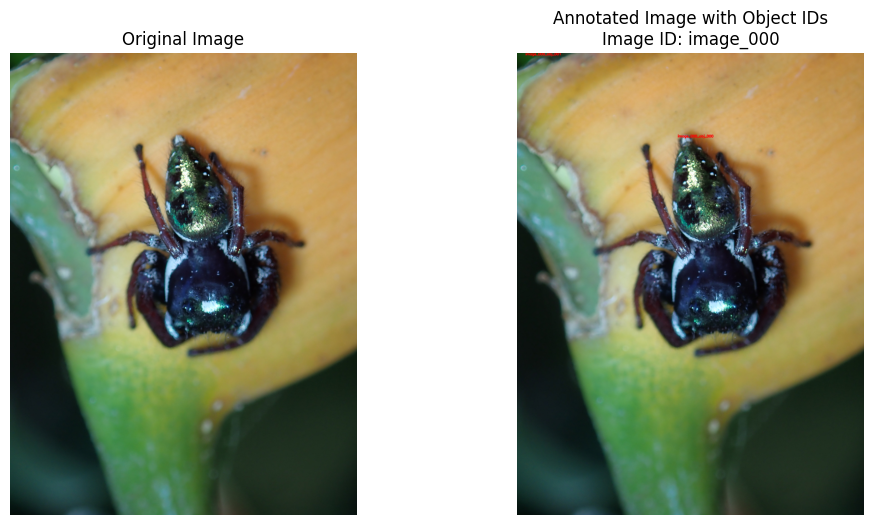

In [24]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import functional as F

# Function to create a summary table
def create_summary_table(data_mapping):
    df = pd.DataFrame(data_mapping)
    df.to_csv('summary_table.csv', index=False)
    return df

# Function to annotate the original image with object IDs
def annotate_image(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            y, x = np.where(mask > 0)
            if len(y) > 0 and len(x) > 0:
                object_id_str = f'{master_id}_obj_{object_id:03d}'
                cv2.putText(image_np, object_id_str, (x[0], y[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                object_id += 1
    return image_np

# Load and annotate an example image
example_image_path = image_paths[0]  # Use the first image for demonstration
example_image = Image.open(example_image_path).convert("RGB")

# Convert the image to tensor and perform predictions
example_image_tensor = transform(example_image).unsqueeze(0)

with torch.no_grad():
    example_predictions = mask_rcnn_model(example_image_tensor)

master_id_example = 'image_000'
annotated_image = annotate_image(example_image, example_predictions, master_id_example)

# Convert annotated image to displayable format
annotated_image_pil = Image.fromarray(annotated_image)

# Display the images and ID
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(example_image)
plt.axis('off')
plt.title('Original Image')

# Annotated image
plt.subplot(1, 2, 2)
plt.imshow(annotated_image_pil)
plt.axis('off')
plt.title(f'Annotated Image with Object IDs\nImage ID: {master_id_example}')

plt.show()


In [34]:
import time
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import functional as F
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# Function to create a summary table
def create_summary_table(data_mapping):
    df = pd.DataFrame(data_mapping)
    df.to_csv('summary_table.csv', index=False)
    return df

# Function to annotate the original image with object IDs
def annotate_image(image, predictions, master_id, threshold=0.5):
    image_np = np.array(image)
    object_id = 0
    for i, pred in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = pred[0].mul(255).byte().cpu().numpy()
            y, x = np.where(mask > 0)
            if len(y) > 0 and len(x) > 0:
                object_id_str = f'{master_id}_obj_{object_id:03d}'
                cv2.putText(image_np, object_id_str, (x[0], y[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                object_id += 1
    return image_np

# Function to compute evaluation metrics
def evaluate_model(image_paths, ground_truths, model, transform, threshold=0.5):
    precisions, recalls, f1_scores, aps = [], [], [], []
    start_time = time.time()
    
    for image_path, ground_truth in zip(image_paths, ground_truths):
        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)
        
        with torch.no_grad():
            predictions = model(image_tensor)
        
        # Extract ground truth and predictions
        gt_masks = ground_truth['masks']
        gt_labels = ground_truth['labels']
        pred_masks = [p[0].mul(255).byte().cpu().numpy() for p in predictions[0]['masks']]
        pred_scores = predictions[0]['scores'].cpu().numpy()
        
        # Calculate precision, recall, and F1 score
        # Convert masks to binary arrays for precision/recall calculation
        pred_labels = [1 if score > threshold else 0 for score in pred_scores]
        gt_labels_binary = [1 if label in gt_labels else 0 for label in range(len(pred_masks))]
        
        precision, recall, f1_score, _ = precision_recall_fscore_support(gt_labels_binary, pred_labels, average='binary')
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        
        # Average Precision
        ap = average_precision_score(gt_labels_binary, pred_scores)
        aps.append(ap)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    # Aggregate metrics
    accuracy = np.mean(f1_scores)
    efficiency = total_time / len(image_paths)  # Time per image
    robustness = np.mean(aps)  # Assuming robustness is reflected by average precision
    
    # Print results
    print(f'Accuracy (F1 Score): {accuracy:.4f}')
    print(f'Efficiency (Time per Image): {efficiency:.4f} seconds')
    print(f'Robustness (Average Precision): {robustness:.4f}')
    
    return accuracy, efficiency, robustness

# Example usage
# Define paths to your images and corresponding ground truth data
image_paths = ['/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/004de63c1ac1.jpg', '/kaggle/working/segmented_objects/image_081_obj_002.png']
ground_truths = [{'masks': [...], 'labels': [...]}, {'masks': [...], 'labels': [...]}]  # Replace with actual data

# Evaluate the model
evaluate_model(image_paths, ground_truths, mask_rcnn_model, transform)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Accuracy (F1 Score): 0.0000
Efficiency (Time per Image): 3.8515 seconds
Robustness (Average Precision): 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


(0.0, 3.8515419960021973, 0.0)

In [ ]:
import os

image_directory = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae"
image_files = os.listdir(image_directory)
print("Number of images:", len(image_files))
